##### Grading Feedback Cell

# Question 0 (-2 If not answered)
Please provide the following the data so we can verify your github information and ensure accurate grading:
- Your Name: Chaithra Kopparam Cheluvaiah
- Your SU ID: 326926205

# IST 718: Big Data Analytics

- Professors: 
  - Willard Williamson <wewillia@syr.edu>
  - Emory Creel <emcreel@g.syr.edu>
- Faculty Assistants: 
  - Warren Justin Fernandes <wjfernan@syr.edu>
  - Ruchita Hiteshkumar Harsora <	rharsora@g.syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- Google Colab is the official class runtime environment so you should test your code on Colab before submission.
- Do not modify cells marked as grading cells or marked as do not modify.
- Before submitting your work, remember to check for run time errors with the following procedure:
`Runtime `$\rightarrow$ Factory reset runtime followed by Runtime $\rightarrow$ Run All.  All runtime errors will result in a minimum penalty of half off.
- All plots shall include descriptive title and axis labels.  Plot legends shall be included where possible.  Unless stated otherwise, plots can be made using any Python plotting package.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- import * is not allowed because it is considered a very bad coding practice and in some cases can result in a significant delay (which slows down the grading process) in loading imports.  For example, the statement `from sympy import *` is not allowed.  You must import the specific packages that you need. 
- The graders reserve the right to deduct points for subjective things we see with your code.  For example, if we ask you to create a pandas data frame to display values from an investigation and you hard code the values, we will take points off for that.  This is only one of many different things we could find in reviewing your code.  In general, write your code like you are submitting it for a code peer review in industry.  
- Level of effort is part of our subjective grading.  For example, in cases where we ask for a more open ended investigation, some students put in significant effort and some students do the minimum possible to meet requirements.  In these cases, we may take points off for students who did not put in much effort as compared to students who put in a lot of effort.  We feel that the students who did a better job deserve a better grade.  We reserve the right to invoke level of effort grading at any time.
- Your notebook must run from start to finish without requiring manual input by the graders.  For example, do not mount your personal Google drive in your notebook as this will require graders to perform manual steps.  In short, your notebook should run from start to finish with no runtime errors and no need for graders to perform any manual steps.

In [1]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already installed
pip install pyspark >& /dev/null 

# Download the data files from github
# If the data file does not exist in the colab environment
data_file_1=US_Airline_Tweets.csv

if [[ ! -f ./${data_file_1} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/${data_file_1} >& /dev/null 
fi

In [2]:
#creating spark session and spark context
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ist718-hw04-sentiment-analysis').getOrCreate()
sc = spark.sparkContext

In [3]:
spark # checking the spark version

In [4]:
# loading required libraries
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType, DoubleType, ArrayType, StringType
from pyspark.ml import Pipeline, feature, classification
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sentiment Analysis
In this assignment, you will use a twitter US airline dataset to perform sentiment analysis.  Specifically, you will use twitter data to predict the sentiment of tweets related to peoples experience with an airline.

In [5]:
# Grading cell
# The purpose of the following boolean is to enable or disable grid search (see question 6a).  
# During grading we want to turn grid search off.  
# You should test your code with grid search set to False before submitting.
# Your notebook should run in its entirety without crashing when enable_grid is
# set to False before submitting.
enable_grid = False

##### Grading Feedback Cell

# Qustion 1: (10 pts)
Read US_Airline_Tweets.csv into a spark dataframe named `tweets_df`.  Drop all columns except airline_sentiment, airline, and text.  Drop rows in which the airline_sentiment column is labeled with a neutral sentiment.  Drop rows which contain NA / Null values in any column. Transform the airline_sentiment column such that a negative sentiment is equal to 0 and a positive sentiment is equal to 1.  This dataset has a lot more negative than positive tweets.  Balance the dataset such that the percentage of negative and positive tweets is roughly 50% each.  Your solution must **randomly sample** the dataset **without replacement** to perform balancing.  Determine and print the resulting percentage of positive and negative tweets in the dataframe such that it's easy for the graders to find and interpret your data.

In [6]:
tweets_df = spark.read.csv('US_Airline_Tweets.csv', header=True, inferSchema=True)

# retaining only few columns - airline_sentiment, airline, and text
tweets_df = tweets_df.select('airline_sentiment','airline','text')

# removing neutral sentiments
tweets_df = tweets_df.filter(f.col('airline_sentiment') != 'neutral')

# removing NA/Null values
tweets_df = tweets_df.dropna(how='any')

# transfomring sentiments
map_sentiments = f.udf(lambda sentiment: 1 if sentiment == 'positive' else 0, IntegerType())
tweets_df = tweets_df.withColumn('airline_sentiment', map_sentiments(f.col('airline_sentiment')))

# handling class imbalance
# sampleBy: Returns a stratified sample without replacement based on the fraction given on each stratum.
tweets_df = tweets_df.sampleBy(col='airline_sentiment',fractions={0:0.2601, 1:1.0}, seed=10272022)


# percentage of positive and negative tweets after sampling
balanced_df = tweets_df.select('airline_sentiment').groupBy('airline_sentiment').count()
balanced_df = balanced_df.withColumn('percentage', f.round((f.col('count')*100/tweets_df.count()),2))
balanced_df.show()

+-----------------+-----+----------+
|airline_sentiment|count|percentage|
+-----------------+-----+----------+
|                1| 2363|      49.1|
|                0| 2450|      50.9|
+-----------------+-----+----------+



In [7]:
# grading cell do not modify
tweets_pd = tweets_df.toPandas()
display(tweets_pd.head())
print(tweets_pd.shape)

,airline_sentiment,airline,text
0,1,Virgin America,@VirginAmerica plus you've added commercials t...
1,1,Virgin America,"@VirginAmerica yes, nearly every time I fly VX..."
2,1,Virgin America,"@virginamerica Well, I didn't…but NOW I DO! :-D"
3,1,Virgin America,"@VirginAmerica it was amazing, and arrived an ..."
4,1,Virgin America,@VirginAmerica I &lt;3 pretty graphics. so muc...


(4813, 3)


##### Grading Feedback Cell

# Question 2: (10 pts)
Pre-process the data by creating a pipeline named `tweets_pre_proc_pipe`. Your pipeline should tokenize, remove stop words, and do a TF-IDF transformation.  Fit and execute your pipeline, and create a new dataframe named `tweets_pre_proc_df`.  Print the shape of the resulting TF-IDF data such that it's easy for the graders to find and understand as num rows x num words. Based on the shape of the TF-IDF data, would you expect a logistic regression model to overfit?

In [8]:
# stage 1: Tokenizer
from pyspark.ml.feature import RegexTokenizer

tokenizer = RegexTokenizer().setGaps(False).setPattern("\\p{L}+").setInputCol("text").setOutputCol("words")

In [9]:
# stage 2: Stop word removal
from pyspark.ml.feature import StopWordsRemover
import requests

# obtaining the stop words from a website
stop_words = requests.get('https://raw.githubusercontent.com/wewilli1/ist718_data/master/stop_words.txt').text.split()

sw_filter = StopWordsRemover().setStopWords(stop_words).setCaseSensitive(False).setInputCol("words").setOutputCol("filtered")

In [10]:
# stage 3: TF-IDF transformation

from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF

# minDF: will remove words that appear in less than 5 docs
cv = CountVectorizer(minTF=1, minDF=5).setInputCol("filtered").setOutputCol("tf")
idf = IDF(minDocFreq=1).setInputCol('tf').setOutputCol('tfidf')

In [11]:
# assembling all the stages - tokenizer, stop word removal, tf, idf
tweets_pre_proc_pipe = Pipeline(stages=[tokenizer, sw_filter, cv, idf])
tweets_pre_proc_fitted = tweets_pre_proc_pipe.fit(tweets_df)
tweets_pre_proc_df = tweets_pre_proc_fitted.transform(tweets_df)

In [12]:
num_rows = tweets_pre_proc_fitted.stages[-1].numDocs
num_cols = len(tweets_pre_proc_fitted.stages[-2].vocabulary)
shape_tfidf = (num_rows,num_cols)
print('Shape of TF_IDF matrix:', shape_tfidf)

Shape of TF_IDF matrix: (4813, 1234)


In [13]:
# grading cell do not modify
tweets_pre_proc_df.show(10)

+-----------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|airline_sentiment|       airline|                text|               words|            filtered|                  tf|               tfidf|
+-----------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                1|Virgin America|@VirginAmerica pl...|[virginamerica, p...|[virginamerica, p...|(1234,[19,32,81,4...|(1234,[19,32,81,4...|
|                1|Virgin America|@VirginAmerica ye...|[virginamerica, y...|[virginamerica, y...|(1234,[2,14,19,39...|(1234,[2,14,19,39...|
|                1|Virgin America|@virginamerica We...|[virginamerica, w...|[virginamerica, d...|(1234,[2,19,90,12...|(1234,[2,19,90,12...|
|                1|Virgin America|@VirginAmerica it...|[virginamerica, i...|[virginamerica, a...|(1234,[19,35,38,7...|(1234,[19,35,38,7...|
|                1|V

##### Grading Feedback Cell

Your explanation here: 

The simple models (less featuers) have better performance with small datasets and the complex models (more features) have better performance with large datasets.

When we look at the shape of TF-IDF matrix, there are too many features (1,233 words in the vocaubulary) and not enough data (4,813 observations).We therefore have a complex model with small dataset. The model would keep learning but we dont have enough data. Overfitting could result from this.

##### Grading Feedback Cell

# Question 3: (10 pts)
Since IDF considers a word's frequency across all documents in a corpus, you can use IDF as a form of inference.  Examine the documentation for the spark ML object that you used to create TF-IDF scores and learn how to extract the IDF scores for words in the corpus.  The idf object in your pipeline has a `values` attribute and a `tolist()` method which can be used to extract IDF values.  Create a pandas dataframe containing the 5 most important IDF scores named `most_imp_idf`.  Create another pandas dataframe containing the 5 least important IDF scores named `least_imp_idf`.  Each dataframe shall have 2 columns named `word` and `idf_score`.  Explain in words your interpretation of what the IDF scores mean.

In [14]:
vocabulary = tweets_pre_proc_fitted.stages[-2].vocabulary

vector_udf = f.udf(lambda sparse_vector: sparse_vector.values.tolist(), ArrayType(DoubleType()))
maxindex_udf = f.udf(lambda sparse_vector: [vocabulary[index] for index in sparse_vector.indices.tolist()], ArrayType(StringType()))

idf_df = tweets_pre_proc_df.select(maxindex_udf('tfidf').alias('words'),vector_udf('tfidf').alias('idf_scores'))\
          .withColumn('merge',f.arrays_zip('words','idf_scores'))\
          .withColumn('word_score',f.explode('merge'))\
          .select(f.col('word_score.words').alias('word'),f.col('word_score.idf_scores').alias('idf_score'))\
          .groupBy(f.col('word'), f.col('idf_score')).agg(f.max(f.col('word')))\
          .select('word','idf_score')\
          .orderBy(f.col('idf_score').desc())

In [15]:
# creating pandas datafarame with top and least important words based on tf-idf scores

idf_pd = idf_df.toPandas()

most_imp_idf = idf_pd.head(5)
least_imp_idf = idf_pd.tail(5)

In [16]:
# grading cell do not modify
display(most_imp_idf)
display(least_imp_idf)

,word,idf_score
0,worst,27.053950
1,q,20.062572
2,god,18.846177
3,plz,18.846177
4,oscars,18.530096


,word,idf_score
1541,americanair,1.674669
1542,southwestair,1.672454
1543,usairways,1.645175
1544,flight,1.589692
1545,united,1.394219


##### Grading Feedback Cell

Your explanation here: 

**Term frequency** is the importance of the term within that document. **Inverse document frequency** determines the importance of the term in the corpus. We get a sense of how important a term is compared to the corpus of all the documents.

$$ IDF = log(\frac{number\_of\_documents}{number\_of\_documents\_containing\_word})$$

As a term appears in more documents in the corpus, the **IDF** decreases thus making the term less important. 

The rate of decrease is slow due to the log function


##### Grading Feedback Cell

# Question 4: (10 pts)
Create a new recursive pipeline named `lr_pipe` which encapsulates `tweets_pre_proc_pipe` and adds a logistic regression model and any needed logistic regression support objects.  Use default logistic regression hyper parameters.  Fit lr_pipe using `tweets_df`.  Score the model using ROC AUC.  Report the resulting AUC such that it is easy for graders to find and interpret.

In [17]:
# model building and predictions
lr_pipe = Pipeline(stages=[tweets_pre_proc_pipe, 
                           classification.LogisticRegression(featuresCol='tfidf', labelCol='airline_sentiment')])

tweets_train_df, tweets_test_df = tweets_df.randomSplit([0.8, 0.2], seed=3157280657)

sentiment_clf = lr_pipe.fit(tweets_train_df)
sentiment_predictions = sentiment_clf.transform(tweets_test_df)

In [18]:
# model evaluation
clf_evaluator = BinaryClassificationEvaluator(labelCol= lr_pipe.getStages()[-1].getLabelCol(),
                                              rawPredictionCol=lr_pipe.getStages()[-1].getPredictionCol(),
                                              metricName='areaUnderROC')
auc_score = clf_evaluator.evaluate(sentiment_predictions)
auc_score = np.round(auc_score,2)
print('AUC',auc_score)

# training accuracy
# clf_auc = clf_evaluator.evaluate(sentiment_clf.transform(tweets_train_df))
# print('Training AUC',clf_auc)


AUC 0.78


##### Grading Feedback Cell

# Question 5: (10 pts)
Create 2 pandas dataframes named `lr_pipe_df_neg` and `lr_pipe_df_pos`which contain 2 colunms: `word` and `score`.  Load the 2 dataframes with the top 10 words and logistic regression coefficients that contribute the most to negative and positive sentiments respectively. Analyze the 2 dataframes and describe if the words make sense.  Do the words look like they are really negative and positive?

In [19]:
vocab = sentiment_clf.stages[0].stages[-2].vocabulary
weights = sentiment_clf.stages[-1].coefficients.toArray()

coeffs_df = pd.DataFrame({'word': vocab, 'weight': weights})

In [20]:
lr_pipe_df_neg = coeffs_df.sort_values('weight').head(10)
lr_pipe_df_pos = coeffs_df.sort_values('weight', ascending=False).head(10)

In [21]:
# grading cell - do not modify
display(lr_pipe_df_neg)
display(lr_pipe_df_pos)

,word,weight
243,pay,-33.228504
934,incompetent,-31.932460
345,talk,-29.200774
690,hasn,-28.196157
685,tsa,-25.471892
992,patience,-24.384461
466,sit,-23.981574
591,lga,-23.715915
309,asked,-23.112370
117,stuck,-22.621350


,word,weight
892,stewardess,31.360062
9,thank,30.254022
798,nashville,29.719350
333,easy,28.696289
274,excellent,26.533309
248,kudos,25.171947
782,fault,23.825255
504,lovely,22.986982
433,haha,22.272287
17,great,20.403413


##### Grading Feedback Cell

Your explanation here:

When we examine the positive words, the majority of them make sense, but a few of them shouldn't have been labelled with postive sentiment. For instance, "nashville," which is a city. A city cannot be classified as positive. Another illustration, the word "Fault", this word should have been categorised negative.

The majority of the negative words, such as "pay","talk","sit", and "asked", are neutral.

We can infer that the model might be overfitting by looking at the overall predictions. Because some of the negative words are incorrectly classified as positive.

##### Grading Feedback Cell

# Question 6a: (5 pts)
The goal of this question is to try to improve the score from question 4 using an elastic net regularization grid search on a new pipeline named `lr_pipe_1`. lr_pipe_1 is the same as lr_pipe above but we would like you to create a new pipe for grading purposes only.  I'm not sure if it's possible to increase the score or not.  You will be graded on level of effort to increase the score in relation to other students in the class.  All of your grid search code should be inside the `if enable_grid` statement in the cell below.  The enable_grid boolean is set to true in a grading cell above.  If any of the grid search code executes outside of the if statement, you will not get full credit for the question.  We want the ability to turn off the grid search during grading.<br>

In [22]:
if enable_grid:
  clf = classification.LogisticRegression(featuresCol='tfidf', labelCol='airline_sentiment')
  lr_pipe_1 = Pipeline(stages=[tweets_pre_proc_pipe, clf])
  grid = ParamGridBuilder().addGrid(clf.regParam, [0., 0.01, 0.02]).addGrid(clf.elasticNetParam, [0., 0.2, 0.4]).build()

  # building the models
  all_models = []
  for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = lr_pipe_1.fit(tweets_train_df, grid[j])
    all_models.append(model)
  
  clf_evaluator_1 = BinaryClassificationEvaluator(labelCol= lr_pipe_1.getStages()[-1].getLabelCol(),
                                                  rawPredictionCol=lr_pipe_1.getStages()[-1].getPredictionCol(),
                                                  metricName='areaUnderROC')
  # evaluating the models
  auc_scores = [clf_evaluator_1.evaluate(model.transform(tweets_test_df)) for model in all_models]
  print(auc_scores)

  best_model_idx = np.argmax(auc_scores)
  print("best model index =", best_model_idx)

  print(grid[best_model_idx])

##### Grading feedback cell

# Question 6b (5 pts)
Build a new pipeline named `lr_pipe_2` which uses the optimized model parameters from the grid search in question 6a above (the best model).  Create 2 variables named alpha and lambda and assign to them the best alpha and lambda produced by the grid search by hard coding the values. Fit and transform lr_pipe_2.  Compare AUC scores between lr_pipe_2 with lr_pipe in question 4.  Create a pandas dataframe named `comapre_1_df` which encapsulates the comparison data.  comapre_1_df Shall have 2 columns: `model_name` and `auc_score`.

In [23]:
best_lambda = 0.02
best_alpha = 0.4

# model building and predictions
lr_pipe_2 = Pipeline(stages=[tweets_pre_proc_pipe, 
                             classification.LogisticRegression(featuresCol='tfidf', labelCol='airline_sentiment', 
                                                               regParam=best_lambda, elasticNetParam=best_alpha)])

sentiment_clf_2 = lr_pipe_2.fit(tweets_train_df)
sentiment_predictions_2 = sentiment_clf_2.transform(tweets_test_df)


# model evaluation
clf_evaluator_2 = BinaryClassificationEvaluator(labelCol= lr_pipe_2.getStages()[-1].getLabelCol(),
                                                rawPredictionCol=lr_pipe_2.getStages()[-1].getPredictionCol(),
                                                metricName='areaUnderROC')
auc_score_2 = clf_evaluator_2.evaluate(sentiment_predictions_2)
auc_score_2 = np.round(auc_score_2,2)
print('AUC',auc_score_2)

# training accuracy
# clf_auc_2 = clf_evaluator_2.evaluate(sentiment_clf_2.transform(tweets_train_df))
# print('Training AUC',clf_auc_2)

AUC 0.85


In [24]:
print('AUC',np.round(auc_score_2,2))


AUC 0.85


In [25]:
comapre_1_df = pd.DataFrame(data={'model_name':['lr_pipe','lr_pipe_2'], 'auc_score':[auc_score, auc_score_2]})

In [26]:
# grading cell - do not modify
display(comapre_1_df)

,model_name,auc_score
0,lr_pipe,0.78
1,lr_pipe_2,0.85


##### Grading Feedback Cell

# Question 7 (10 pts)
Perform inference on lr_pipe_2.  Write code to report how many words were eliminated from the best model in question 6b above (if any) as compared to the model in question 4 above.  Make sure your output is easy for the graders to find and interpret.

Describe in words how feature selection is performed using elastic net regularization.

In [27]:
best_model_weights = sentiment_clf_2.stages[-1].coefficients.toArray()
best_model_vocab = sentiment_clf_2.stages[0].stages[2].vocabulary

best_inference_df = pd.DataFrame({'word':best_model_vocab, 'weights':best_model_weights})
best_eliminated_words = best_inference_df[best_inference_df['weights'] == 0]
best_eliminated_words.shape

(711, 2)

In [28]:
model_weights = sentiment_clf.stages[-1].coefficients.toArray()
model_vocab = sentiment_clf.stages[0].stages[2].vocabulary

inference_df = pd.DataFrame({'word':model_vocab, 'weights':model_weights})
eliminated_words = inference_df[inference_df['weights'] == 0]
eliminated_words.shape

(0, 2)

In [29]:
results = pd.DataFrame({'Model':['lr_pipe_2','lr_pipe'],'Num Words Eliminated':[best_eliminated_words.shape[0], eliminated_words.shape[0]]})
results

,Model,Num Words Eliminated
0,lr_pipe_2,711
1,lr_pipe,0


##### Grading Feedback Cell

Your explanation here:

Elasticnet regularization is a combination of L1(Lasso) and L2(Ridge) regularization. L1 regularization helps in feature selection in addition to fixing the overfitting problem.

\begin{equation}
L_\theta^{\lambda,\alpha}(p(X),Y) = -\left( \sum_i Y_i \log p_\theta(X_i) + (1-Y_i)\log (1-p_\theta(X_i)) \right) + \lambda \left[(1-\alpha) \sum_{j>0} \theta_j^2 + \alpha \sum_{j>0} \left| \theta_j \right| \right]
\end{equation}

The slopes/weights of some features that are not significant will shrink to 0 when try to minimize the above alternative loss function to 0.Hence, performing feature selection.

##### Grading Feedback Cell

# Question 8 (10 pts)
Perform the same inference analysis that you did in question 5 but name the data frames `lr_pipe_df_neg_1` and `lr_pipe_df_pos_1`.  Compare the word importance results with the results in question 5.  Do the most positive and most negative words produced by using regularization better reflect positive and negative sentiment than the most positive and negative words produced by the model that did not use regularization?

In [30]:
vocab_2 = sentiment_clf_2.stages[0].stages[-2].vocabulary
weights_2 = sentiment_clf_2.stages[-1].coefficients.toArray()

coeffs_df_2 = pd.DataFrame({'word': vocab_2, 'weight': weights_2})

In [31]:
lr_pipe_df_neg_1 = coeffs_df_2.sort_values('weight').head(10)
lr_pipe_df_pos_1 = coeffs_df_2.sort_values('weight', ascending=False).head(10)

In [32]:
# grading cell - do not modify
display(lr_pipe_df_neg_1)
display(lr_pipe_df_pos_1)

,word,weight
3,usairways,-0.376895
24,hours,-0.348331
25,delayed,-0.346097
28,hold,-0.275427
41,hour,-0.264755
111,worst,-0.251190
2,t,-0.243220
14,cancelled,-0.230178
117,stuck,-0.226973
722,feedback,-0.200697


,word,weight
7,thanks,1.026973
9,thank,1.015780
17,great,0.502073
53,awesome,0.426776
248,kudos,0.412695
30,love,0.389550
42,best,0.374107
274,excellent,0.356829
78,amazing,0.332006
6,jetblue,0.327509


##### Grading Feedback Cell

Your explanation here:

In comparison to the preceding model without regularization, the model with regularization performs fairly well. The majority of the positive words are classified accurately, however the classification of negative words could still be improved.

Some of the negative words, such as "usairways," "hours," and "feedback," are actually neutral. Perhaps, model predictions would have been more accurate if we had "neutral" reviews in the dataset.

##### Grading Feedback Cell

# Question 9 (10 pts)
Precision recall plots are very similar to receiver operating characteristic (ROC) curves.  The high level steps for creating a precision recall curve are the same as the steps needed to create a ROC curve as outlined in lecture. Learn about [precision recall curves](https://en.wikipedia.org/wiki/Precision_and_recall).  Create a precision recall plot for the best model in question 6.  Describe what axes are the same / different between the precision recall curve and the ROC curve.

In [33]:
# see https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


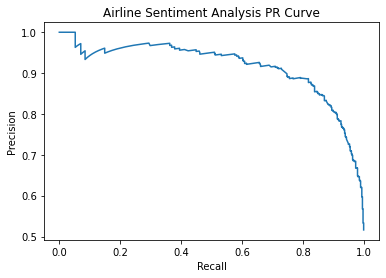

In [34]:
# Returns as a list (false positive rate, true positive rate)
label_col = lr_pipe_2.getStages()[-1].getLabelCol()
probabilty_col = sentiment_clf_2.stages[-1].getProbabilityCol()

preds = sentiment_predictions_2.select(label_col,probabilty_col).rdd.map(lambda row: (float(row[probabilty_col][1]), float(row[label_col])))
points = CurveMetrics(preds).get_curve('pr')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Airline Sentiment Analysis PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(x_val, y_val)

##### Grading Feedback Cell

Your explanation here:

The x-axis in ROC cuve has False Postive Rate (FPR) and the PR curve has Recall. The y-axis in ROC curve has True Positive Rate(TPR) and PR curve has Precision.

##### Grading Feedback Cell

# Question 10 (10 pts)
Design and implement a method to rank the airlines in your dataset from best to worst.  Your solution can use model predictions or inference or both to perform this task. Implement your ranking algorithm in spark.  Create a spark dataframe named airline_rankings.  airline_rankings Shall have 3 columns: airline_name, num_reviews, and ranking.  Load the num_reviews column with the number of reviews associated with the airline.  Load the ranking column with your rank calculation result.  Sort airline rankings from best to worst (best at head, worst at tail).  

Describe in words how your algorithm works in clear easy to understand language.  We will take points off for descriptions that are not clearly stated and easy to follow.  We don't expect to have to reverse engineer your code understand how your algorithm works.

In [35]:
final_pred = sentiment_clf_2.transform(tweets_df)

# replacing negative sentiment with '-1'
final_pred = final_pred.withColumn('new_pred', f.when(f.col('prediction')==0, -1).otherwise(1))

In [36]:
airline_rankings = final_pred.groupBy('airline')\
                  .agg(f.count('airline').alias('num_reviews'), f.sum('new_pred').alias('diff'))\
                  .withColumn('ranking', f.round((f.col('diff')*100/f.col('num_reviews')),2))\
                  .orderBy(f.col('ranking').desc())\
                  .select('airline','num_reviews','ranking')

##### Grading Feedback Cell

Your algorithm description here:

Below steps are used to determine airlines ranking:
1. Find the number of positive reviews for a particular airline
2. Find the number of negative reviews for a particular airline
3. Find difference between positive and negative reviews
5. Find the percentage of difference by dividing the difference by total number of reviews and multiplying by 100


 $$ rank = \frac{(num\_positive\_reviews) - (num\_negative\_reviews)}{total\_reviews} * 100
$$


In [37]:
# grading cell do not modify
display(airline_rankings.toPandas().head())
display(airline_rankings.toPandas().tail())

,airline,num_reviews,ranking
0,Virgin America,205,62.93
1,Delta,785,46.24
2,Southwest,894,32.21
3,American,845,-28.05
4,United,1180,-29.32


,airline,num_reviews,ranking
1,Delta,785,46.24
2,Southwest,894,32.21
3,American,845,-28.05
4,United,1180,-29.32
5,US Airways,904,-51.33


##### Grading Feedback Cell

# Question 11 (0 pts)
Make sure to set enable_grid to False in the grading cell above and run the notebook in its entirety before submitting to verify that there are no runtime erros.  

##### Grading Feedback Cell